In [1]:
import DQRL
from tqdm import tqdm
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
trainCP = gym.make('CartPole-v1')
numInputs = trainCP.observation_space.shape[0]
numActions = trainCP.action_space.n

In [3]:
N = 125
score = 0
scores = []
episode = 0
EPISODES = 25000
agent = DQRL.DQN(learningRate = 8e-4, discountRate = 0.99,
                 numInputs = numInputs, numActions = numActions, nodes = (512, 512), tau = 2e-2, sync = 4*trainCP.spec.max_episode_steps,
                 epsMax = 1.00, epsMin = 0.05, epsDec = EPISODES*6//7,
                 capacity = 64*trainCP.spec.max_episode_steps, batchSize = 64, updates = 64)

ep: 0, score:0:   0%|                                                                              | 0/25000 [00:00<?, ?it/s]/home/pranav/Workspace/RL/src/Q-Learning/DeepQ/DQRL.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  batchS  = torch.FloatTensor([self.bufferS[idx]  for idx in indices]).to(DEVICE)
/home/pranav/Workspace/RL/src/Q-Learning/DeepQ/DQRL.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, device=DEVICE, dtype=torch.float32)
ep: 0, score:0: 100%|██████████████████████████████████████████████████████████████████| 25000/25000 [25:01<00:00, 16.65it/s]


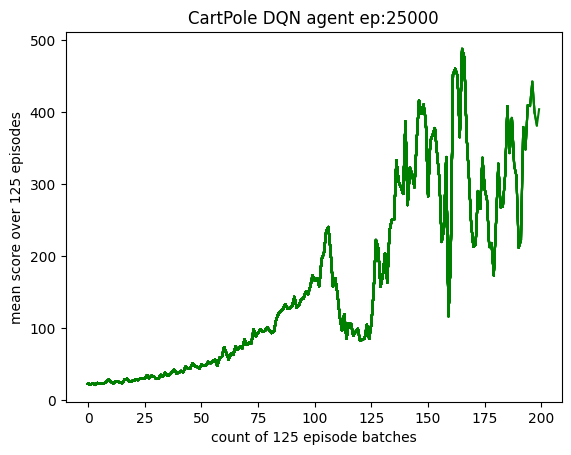

In [4]:
for episode in tqdm(range(1,EPISODES+1), desc=f"ep: {episode}, score:{score}", leave=True, ncols=125):
    score = 0
    done = False
    state, info = trainCP.reset(seed = 42)

    while not done:
        action = agent.selectEpsilonGreedyAction(state=state)
        new_state, reward, terminated, truncated, info = trainCP.step(action=action)
        agent.step(state=state, action=action, reward=reward, state_=new_state, terminated=terminated)
        done = terminated or truncated
        score += reward
        state = new_state
    scores.append(score)
    
    if episode % N == 0:
        avgNscores = [sum(scores[k*N:(k+1)*N])/N for k in range(0, episode//N)]
        if avgNscores[-1] == max(avgNscores):
            agent.save('./CPDQN.pt')
        plt.plot(avgNscores, 'g')
        plt.title(f'CartPole DQN agent ep:{episode}')
        plt.xlabel(f'count of {N} episode batches')
        plt.ylabel(f'mean score over {N} episodes')
        plt.savefig('./CPDQN.png')
    
    agent.update()